In [ ]:
#default_exp main

In [ ]:
import os
import pandas as pd
import numpy as np
import transformers

from fastai.text.all import *

from Hasoc import utils
from Hasoc import model

In [ ]:
#export 
MODEL_NAME = 'bert-base-uncased'
MAX_SEQ_LEN = 72
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#export
df = pd.read_csv(os.path.join('../data', 'en_task_a', 'hasoc_2020_en_train_new.csv'), sep='\t')

In [ ]:
#hide
df.sample(2)

,tweet_id,text,task1,task2,ID
1125,1.123530e+18,RT @meaux_meauxx: Please y’all i work to fuckin hard for my shit https://t.co/kRffCRJUsg,HOF,PRFN,hasoc_2020_en_5346
3355,1.123789e+18,RT @kathygriffin: Most of California’s forests are under federal jurisdiction you dumb fuck https://t.co/r4XTaL2DC2,HOF,PRFN,hasoc_2020_en_3193


In [ ]:
#hide
df['task1'].value_counts()

HOF    1856
NOT    1852
Name: task1, dtype: int64

In [ ]:
#hide
df['task2'].value_counts()

NONE    1852
PRFN    1377
OFFN     321
HATE     158
Name: task2, dtype: int64

In [ ]:
#export
df.tweet_id = df.tweet_id.astype('int').astype('str')

In [ ]:
df = df[:1000]

In [ ]:
#export
bert_tokenizer = transformers.BertTokenizer.from_pretrained(
            pretrained_model_name_or_path=MODEL_NAME,
            do_lower_case=True,
            )

In [ ]:
bert_vocab = bert_tokenizer.get_vocab()
bert2fastai_vocab = [k for k, v in sorted(bert_vocab.items(), key=lambda item: item[1])]

In [ ]:
#export 
pad = partial(pad_input_chunk, pad_first=False, pad_idx=bert_tokenizer.pad_token_id, seq_len=MAX_SEQ_LEN)

In [ ]:
#export
custom_tokenizer = Tokenizer.from_df(text_cols='text', tok=utils.HFTokenizer(tokenizer=bert_tokenizer), rules=[])

In [ ]:
#export
tfms = [attrgetter('text'), custom_tokenizer, Numericalize(vocab=bert2fastai_vocab), utils.Add_Special_Cls(tokenizer=bert_tokenizer)]

In [ ]:
#export
splits = RandomSplitter()(df)

In [ ]:
#export
dsets = Datasets(df, tfms=[tfms, [attrgetter('task1'), Categorize()]], splits=splits, dl_type=SortedDL)

In [ ]:
#export
dls_clas = dsets.dataloaders(bs=56, val_bs=144, before_batch=[pad], seq_len=MAX_SEQ_LEN)

In [ ]:
#export
dls_clas.show_batch(max_n=2)

,text,category
0,[CLS] rt @ sud ##out ##ats ##uy ##a : eat shit grammar nazis ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! [SEP],HOF
1,[CLS] rt @ na ##lu _ for _ you : after na ##lu one of my favourite [UNK] - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - … [SEP] [PAD] [PAD] [PAD] [PAD] [PAD],NOT


In [ ]:
#export
modeller = model.HasocModel(out_feat=dsets.c)

In [ ]:
#export
learn = Learner(dls_clas, modeller.to(device), metrics=[accuracy, F1Score(average='macro')], drop_mult=0.3, device=device, loss_func=CrossEntropyLossFlat())

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=0.0004786300996784121)

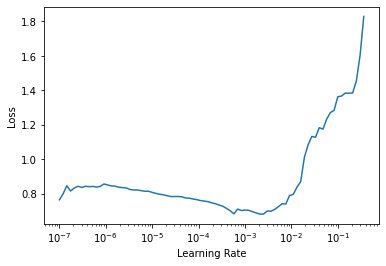

In [ ]:
#export
learn.lr_find()

In [ ]:
#export
lr = 4e-4

learn.fit_one_cycle(7, lr, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.671186,0.518316,0.670000,0.641927,00:12
1,0.533450,0.328321,0.905000,0.904998,00:13
2,0.454438,0.588561,0.750000,0.728733,00:12
3,0.399530,0.250230,0.910000,0.909420,00:13
4,0.346138,0.272285,0.905000,0.904979,00:13
5,0.273101,0.321449,0.895000,0.894976,00:13
6,0.205155,0.315423,0.905000,0.904941,00:14


In [ ]:
#export
learn.export(os.path.join('models', 'task1.pkl'))

## Task2

In [ ]:
#export
dsets = Datasets(df, tfms=[tfms, [attrgetter('task2'), Categorize()]], splits=splits, dl_type=SortedDL)

In [ ]:
#export
dls_clas = dsets.dataloaders(bs=56, val_bs=144, before_batch=[pad], seq_len=MAX_SEQ_LEN)

In [ ]:
#export
dls_clas.show_batch(max_n=2)

,text,category
0,[CLS] rt @ sud ##out ##ats ##uy ##a : eat shit grammar nazis ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! [SEP],OFFN
1,[CLS] rt @ na ##lu _ for _ you : after na ##lu one of my favourite [UNK] - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - … [SEP] [PAD] [PAD] [PAD] [PAD] [PAD],NONE


In [ ]:
#export
modeller = model.HasocModel(out_feat=dsets.c)

No weighting

In [ ]:
#export
learn = Learner(dls_clas, modeller.to(device), metrics=[accuracy, F1Score(average='macro')], drop_mult=0.3, device=device, loss_func=CrossEntropyLossFlat())

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=0.0003981071640737355)

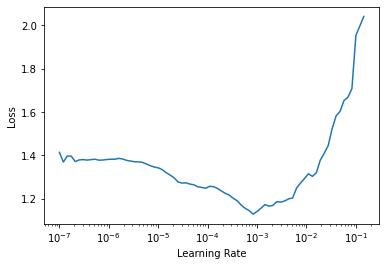

In [ ]:
#export
learn.lr_find()

In [ ]:
#export
lr = 4e-4

learn.fit_one_cycle(7, lr, moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.073818,0.599817,0.840000,0.433224,00:13
1,0.956251,0.535677,0.850000,0.441184,00:12
2,0.814303,0.591097,0.825000,0.475653,00:11
3,0.782117,0.507319,0.865000,0.447220,00:12
4,0.739601,0.537395,0.855000,0.447963,00:13
5,0.699204,0.535535,0.845000,0.445641,00:12
6,0.650269,0.524630,0.850000,0.448606,00:12


In [ ]:
#export
learn.export(os.path.join('models', 'task2.pkl'))

## interp

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

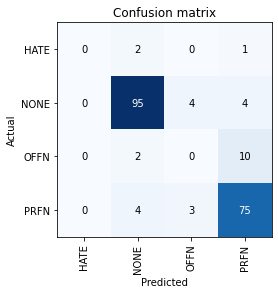

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

[('OFFN', 'PRFN', 10),
 ('NONE', 'OFFN', 4),
 ('NONE', 'PRFN', 4),
 ('PRFN', 'NONE', 4),
 ('PRFN', 'OFFN', 3),
 ('HATE', 'NONE', 2),
 ('OFFN', 'NONE', 2),
 ('HATE', 'PRFN', 1)]

In [ ]:
learn.predict('What the fuck are you talking. go to hell')

('PRFN', tensor(3), tensor([0.0356, 0.0196, 0.0795, 0.8652]))

In [ ]:
learn.predict("I will chop off your head and kill you")

('NONE', tensor(1), tensor([0.0381, 0.8502, 0.0482, 0.0635]))